In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(2023)

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

https://www.kaggle.com/competitions/titanic/data  에서 타이타닉 생존자 데이터셋 (train, test, submission) 다운로드

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [88]:
train = pd.read_csv("/content/drive/MyDrive/ToBigs/19기 정규세션/train.csv")
test = pd.read_csv("/content/drive/MyDrive/ToBigs/19기 정규세션/test.csv")
target = pd.read_csv("/content/drive/MyDrive/ToBigs/19기 정규세션/submission.csv")

In [89]:
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [90]:
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

단순 식별자 feature 등은 제거하기로 결정
* 'PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin', 'Embarked' 제거

In [91]:
train_target = train['Survived']
train_data = train.drop(['Survived', 'PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1)
test = test.drop(['PassengerId', 'Name', 'Ticket', 'Fare', 'Cabin', 'Embarked'], axis=1)

In [92]:
train_data

,Pclass,Sex,Age,SibSp,Parch
0,3,male,22.0,1,0
1,1,female,38.0,1,0
2,3,female,26.0,0,0
3,1,female,35.0,1,0
4,3,male,35.0,0,0
...,...,...,...,...,...
886,2,male,27.0,0,0
887,1,female,19.0,0,0
888,3,female,NaN,1,2
889,1,male,26.0,0,0


In [93]:
#데이터 EDA
train_data.describe()

,Pclass,Age,SibSp,Parch
count,891.000000,714.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594
std,0.836071,14.526497,1.102743,0.806057
min,1.000000,0.420000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000
50%,3.000000,28.000000,0.000000,0.000000
75%,3.000000,38.000000,1.000000,0.000000
max,3.000000,80.000000,8.000000,6.000000


In [94]:
train_data.isna().sum()

Pclass      0
Sex         0
Age       177
SibSp       0
Parch       0
dtype: int64

Age의 경우 다른 변수에 비해 결측치가 많은 것을 확인할 수 있다.

문자형 데이터(범주형)인 성별을 원핫 인코딩 처리 (판다스의 get_dummies 함수를 이용)

In [95]:
train_data = pd.get_dummies(train_data, columns = ["Sex"])
test = pd.get_dummies(test, columns = ["Sex"])

In [96]:
train_data

,Pclass,Age,SibSp,Parch,Sex_female,Sex_male
0,3,22.0,1,0,0,1
1,1,38.0,1,0,1,0
2,3,26.0,0,0,1,0
3,1,35.0,1,0,1,0
4,3,35.0,0,0,0,1
...,...,...,...,...,...,...
886,2,27.0,0,0,0,1
887,1,19.0,0,0,1,0
888,3,NaN,1,2,1,0
889,1,26.0,0,0,0,1


###전체의 평균 이용

> 기본적으로 전체의 평균을 이용해서 결측치를 채워넣을 수 있음



In [97]:
mean_train_data = train_data.copy()
mean_test_data = test.copy()

In [98]:
age_mean = mean_train_data["Age"].mean()
age_mean

29.69911764705882

In [99]:
#age_mean으로 결측치를 채워넣음 (train & test)
mean_train_data.loc[:, "Age"] = mean_train_data["Age"].fillna(age_mean)
mean_test_data.loc[:, "Age"] = mean_test_data["Age"].fillna(age_mean)

In [100]:
mean_train_data.isna().sum()
#모든 결측치가 채워진 것을 확인 가능

Pclass        0
Age           0
SibSp         0
Parch         0
Sex_female    0
Sex_male      0
dtype: int64

### K-means를 활용
> 클러스터링 작업을 통해 같은 군집에 속하는 데이터들의 평균으로 결측치를 채워넣을 수 있음

In [101]:
k_train_data = train_data.copy()
k_test_data = test.copy()

In [102]:
#결측치가 존재하는 Age column을 제외하고 클러스터링을 진행할 것

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(k_train_data.drop(["Age"], axis=1)) #Age를 제외한 변수들 스케일링 (정규화)

train_fill_data = scaler.transform(k_train_data.drop(["Age"], axis=1))
test_fill_data = scaler.transform(k_test_data.drop(["Age"], axis=1))

Elbow method를 이용해 k값 결정 (SSE 찍어보기)

In [103]:
from sklearn.cluster import KMeans

n_cluster = []
sse = []
for n in range(3, 15, 2):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(train_fill_data)
    n_cluster += [n]
    sse += [kmeans.inertia_]

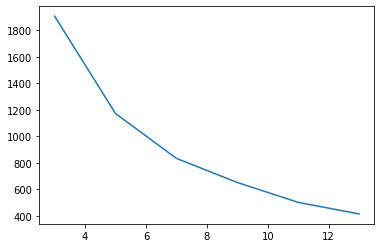

In [104]:
plt.plot(n_cluster, sse)

In [105]:
#elbow point를 7으로 결정
n_clusters = 7

In [106]:
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(train_fill_data)

KMeans(n_clusters=7)

In [107]:
train_fill_data

array([[ 0.82737724,  0.43279337, -0.47367361, -0.73769513,  0.73769513],
       [-1.56610693,  0.43279337, -0.47367361,  1.35557354, -1.35557354],
       [ 0.82737724, -0.4745452 , -0.47367361,  1.35557354, -1.35557354],
       ...,
       [ 0.82737724,  0.43279337,  2.00893337,  1.35557354, -1.35557354],
       [-1.56610693, -0.4745452 , -0.47367361, -0.73769513,  0.73769513],
       [ 0.82737724, -0.4745452 , -0.47367361, -0.73769513,  0.73769513]])

In [108]:
clustered_train = kmeans.predict(train_fill_data)
clustered_test = kmeans.predict(test_fill_data)

In [109]:
print(len(clustered_train))
clustered_train

891


array([4, 0, 5, 0, 4, 4, 6, 2, 3, 0, 5, 0, 4, 3, 5, 0, 2, 1, 5, 5, 1, 1,
       5, 6, 5, 3, 4, 2, 5, 4, 6, 0, 5, 1, 6, 6, 4, 4, 5, 5, 5, 0, 4, 3,
       5, 4, 4, 5, 4, 5, 2, 4, 0, 0, 6, 6, 0, 4, 3, 2, 4, 0, 6, 2, 6, 4,
       0, 4, 2, 4, 1, 2, 1, 4, 4, 4, 4, 4, 1, 5, 4, 4, 5, 6, 0, 5, 3, 4,
       3, 4, 4, 4, 6, 4, 4, 4, 6, 6, 0, 1, 5, 4, 6, 4, 4, 4, 5, 4, 4, 5,
       6, 5, 4, 5, 5, 4, 4, 1, 6, 2, 1, 4, 1, 0, 6, 4, 4, 4, 5, 4, 4, 4,
       5, 0, 1, 1, 3, 6, 4, 6, 3, 5, 5, 4, 1, 1, 4, 3, 1, 1, 1, 0, 4, 4,
       4, 6, 5, 4, 4, 2, 4, 0, 4, 4, 2, 4, 0, 3, 6, 4, 6, 2, 5, 4, 6, 4,
       2, 0, 1, 4, 2, 1, 2, 1, 3, 6, 5, 6, 4, 4, 0, 1, 5, 1, 0, 0, 4, 4,
       5, 0, 4, 2, 4, 4, 4, 5, 4, 4, 5, 6, 4, 0, 4, 1, 4, 0, 5, 1, 0, 1,
       4, 1, 4, 4, 6, 4, 1, 4, 1, 5, 0, 4, 1, 2, 1, 5, 1, 3, 1, 1, 5, 5,
       1, 4, 4, 6, 5, 3, 6, 1, 4, 5, 6, 4, 3, 3, 0, 0, 0, 0, 4, 2, 6, 6,
       5, 1, 2, 4, 0, 0, 6, 4, 0, 6, 5, 0, 5, 1, 2, 5, 4, 4, 4, 4, 6, 4,
       4, 4, 1, 5, 0, 0, 1, 5, 4, 6, 4, 3, 6, 0, 5,

모든 데이터의 군집이 결정된 것을 확인 가능
* 클러스터링이 잘 되었는지 확인하기 위해 실루엣 계수 확인

In [110]:
from sklearn.metrics import silhouette_score

mean_score = silhouette_score(train_fill_data, clustered_train)
print(mean_score)

0.563016053595228


실루엣 계수의 값이 0.5보다 크므로 타당하다고 판단 가능

In [111]:
#각 군집 별 Age 평균값 찾기
cluster_fill_value = {}
for i in range(n_clusters):
    class_mean = k_train_data.loc[clustered_train == i, "Age"].dropna().mean()
    cluster_fill_value[i] = class_mean

cluster_fill_value

{0: 33.650375939849624,
 1: 30.74070707070707,
 2: 7.888888888888889,
 3: 25.48,
 4: 28.066753246753247,
 5: 21.726666666666667,
 6: 41.2769696969697}

In [112]:
train_na_idx = k_train_data.loc[k_train_data["Age"].isna()].index #결측치 존재하는 index
train_fill_value = list(map(lambda x: cluster_fill_value[x], clustered_train[train_na_idx])) #결측치 존재 인덱스에 각 군집에 해당하는 평균 연령값 가져오기

k_train_data.loc[train_na_idx, "Age"] = train_fill_value #결측치에 채워넣기

In [113]:
k_train_data.loc[train_na_idx]

,Pclass,Age,SibSp,Parch,Sex_female,Sex_male
5,3,28.066753,0,0,0,1
17,2,30.740707,0,0,0,1
19,3,21.726667,0,0,1,0
26,3,28.066753,0,0,0,1
28,3,21.726667,0,0,1,0
...,...,...,...,...,...,...
859,3,28.066753,0,0,0,1
863,3,7.888889,8,2,1,0
868,3,28.066753,0,0,0,1
878,3,28.066753,0,0,0,1


결측치 부분이 잘 채워진 것을 확인할 수 있음

In [114]:
#test 데이터에 대해서도 동일한 방법으로 진행
test_na_idx = k_test_data.loc[k_test_data["Age"].isna()].index
test_fill_value = list(map(lambda x: cluster_fill_value[x], clustered_test[test_na_idx]))

k_test_data.loc[test_na_idx, "Age"] = test_fill_value

###예측 진행

In [116]:
mean_random_forest = RandomForestClassifier()
cluster_random_forest = RandomForestClassifier()

In [117]:
mean_random_forest.fit(mean_train_data, train_target)
cluster_random_forest.fit(k_train_data, train_target)

RandomForestClassifier()

In [118]:
mean_test_pred = mean_random_forest.predict(mean_test_data)
cluster_test_pred = cluster_random_forest.predict(k_test_data)

In [122]:
test_label = target['Survived']

In [123]:
#정확도 비교

mean_test_accuracy = accuracy_score(test_label, mean_test_pred)
cluster_test_accuracy = accuracy_score(test_label, cluster_test_pred)

print(f"Test Accuracy for mean data is {mean_test_accuracy:.4f}")
print(f"Test Accuracy for cluster data is {cluster_test_accuracy:.4f}")

Test Accuracy for mean data is 0.8086
Test Accuracy for cluster data is 0.8349


k-means를 통해 결측치를 채웠을 때의 결과가 더 높은 정확성을 가짐을 확인 가능하다.